In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import corner
%matplotlib inline

### Read in pre-training and post-training metadata

In [3]:
from types import SimpleNamespace
import json
import torch

args = json.load(open("args.txt"))
data_meta = json.load(open("data_meta.txt"))
meta = SimpleNamespace(**{**args, **data_meta}) # don't wanna keep track of which comes from which
# FIXME: the whole data flow is hacky

# I need these to be np arrays
for par_name in ['X_mean', 'X_std', 'Y_mean', 'Y_std',]:
    par_list = getattr(meta, par_name)
    setattr(meta, par_name, np.array(par_list))
    
# Configure device, same as trained model
device = torch.device(type=meta.device_type)
if device=='cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

### Read in validation dataset

In [4]:
# Full dataset
X = pd.read_csv("data/processed_X.csv", index_col=False)
Y = pd.read_csv("data/processed_Y.csv", index_col=False)
X = X*meta.X_std + meta.X_mean # Unstandardize
Y = Y*meta.Y_std + meta.Y_mean # Do not unstandardize yet

# Validation set
X_val = X.iloc[meta.val_indices, :]
Y_val = Y.iloc[meta.val_indices, :]

In [5]:
# Subsample for visualization
np.random.seed(123)
n_subsample = 200
subsampled = np.random.choice(Y_val.shape[0], size=n_subsample, replace=False)
X_val_sampled = X_val.iloc[subsampled, :] # shape [n_subsampled, X_dim]
Y_val_sampled = Y_val.iloc[subsampled, :] # shape [n_subsampled, Y_dim]

### Prediction time!

In [7]:
from models import ConcreteDense
from torch.autograd import Variable

length_scale = meta.l
wr = length_scale**2.0/meta.n_train
dr = 2.0/meta.n_train
# FIXME: use val_loader? 
# I hardcoded CPU here b/c the whole validation set doesn't fit on my GPU
model = ConcreteDense(meta.X_dim, meta.Y_dim, meta.n_features, wr, dr)
model.load_state_dict(torch.load('checkpoint/weights_%d.pth' %meta.run_id))
model.eval()

MC_samples = [model(Variable(torch.Tensor(X_val_sampled.values))) for _ in range(meta.n_MC)]

In [9]:
# Slice to get means and logvar separately
means = torch.stack([tup[0] for tup in MC_samples]).view(meta.n_MC, n_subsample, meta.Y_dim).cpu().data.numpy()
logvar = torch.stack([tup[1] for tup in MC_samples]).view(meta.n_MC, n_subsample, meta.Y_dim).cpu().data.numpy()

if not os.path.exists('results'):
    os.makedirs('results')
np.save("results/means_run_%d" %meta.run_id, means.reshape(meta.n_MC, -1))
np.save("results/logvar_run_%d"%meta.run_id, logvar.reshape(meta.n_MC, -1))

In [10]:
# Unstandardize
means = means*meta.Y_std.reshape([1, 1, meta.Y_dim]) + meta.Y_mean.reshape([1, 1, meta.Y_dim]) # broadcasting
# Do not unstandardize log_var yet!

In [11]:
meta.Y_cols

['psFlux_u',
 'psFlux_z',
 'cModelFlux_y',
 'cModelFlux_i',
 'y_obs',
 'IyyPSF',
 'ra_offset',
 'psFlux_i',
 'Ixx',
 'Ixy',
 'r_ext_photometryKron_KronFlux_instFlux',
 'cModelFlux_u',
 'dec_offset',
 'u_ext_photometryKron_KronFlux_instFlux',
 'r_base_CircularApertureFlux_70_0_instFlux',
 'cModelFlux_z',
 'psFlux_y',
 'IxyPSF',
 'i_base_CircularApertureFlux_70_0_instFlux',
 'g_ext_photometryKron_KronFlux_instFlux',
 'psFlux_r',
 'i_ext_photometryKron_KronFlux_instFlux',
 'y_base_CircularApertureFlux_70_0_instFlux',
 'u_base_CircularApertureFlux_70_0_instFlux',
 'g_base_CircularApertureFlux_70_0_instFlux',
 'psFlux_g',
 'y_ext_photometryKron_KronFlux_instFlux',
 'z_ext_photometryKron_KronFlux_instFlux',
 'z_base_CircularApertureFlux_70_0_instFlux',
 'Iyy',
 'cModelFlux_r',
 'IxxPSF',
 'cModelFlux_g',
 'x']

### Plot single-quantity marginal posterior

In [ ]:
from uncertainty_utils import get_astrometric_error, get_photometric_error, assign_obs_error

def plot_flux_mapping(means, logvar, param, band, truth_flux_name='%s_flux', plot_offset=True):
    epistemic_var_full = np.var(means, axis=0)
    aleatoric_var_full = np.mean(np.exp(logvar), axis=0)
    Y_coldict = dict(zip(Y_cols, range(Y_dim)))
    r_mag = units.flux_to_mag(X_val_sampled.loc[:, 'r_flux'].values, from_unit='nMgy')
    
    # Slice for this param
    param_ind = Y_coldict[param]
    mean_avg = np.mean(means, axis=0)[:, param_ind]
    epistemic_var = epistemic_var_full[:, param_ind]
    aleatoric_var = aleatoric_var_full[:, param_ind]
    total_var = aleatoric_var + epistemic_var
    display_var = aleatoric_var + epistemic_var
    display_sig = display_var**0.5
    
    epistemic_sig_mag = (epistemic_var**0.5*u.nJy).to(u.ABmag).value
    aleatoric_sig_mag = (aleatoric_var**0.5*u.nJy).to(u.ABmag).value
    display_sig_mag = aleatoric_sig_mag
    truth = Y_val_sampled.loc[:, param].values
    
    # Plot pred in magnitudes
    mean_avg_mag = (mean_avg*u.nJy).to(u.ABmag).value
    truth_mag = (truth*u.nJy).to(u.ABmag).value
    sorted_id = np.argsort(truth)
    sorted_truth = truth_mag[sorted_id]
    perfect = np.linspace(np.min(truth_mag), np.max(truth_mag))
    obs_err, sys_type = assign_obs_errors(param, Y_coldict, truth_flux_name, truth, r_mag)
   
    if plot_offset:
        offset = mean_avg_mag - truth_mag
        plt.fill_between(truth_mag[sorted_id], -obs_err[sorted_id], obs_err[sorted_id], alpha=0.5, facecolor='tab:orange', label=r'1-$\sigma$ %s' %sys_type)
        plt.errorbar(truth_mag, offset, marker='.', linewidth=0, yerr=display_sig_mag, elinewidth=0.5, label=r'1-$\sigma$ aleatoric')
        
        plt.plot(perfect, np.zeros_like(perfect), linestyle='--', color='r', label="Perfect mapping")
        plt.ylim([-2.0, 2.0])
    else:
        plt.errorbar(truth_mag, mean_avg_mag, marker='.', linewidth=0, yerr=display_sig_mag, elinewidth=0.5, label=r'1-$\sigma$ aleatoric')
        # Plot perfect mapping
        plt.plot(perfect, perfect, linestyle='--', color='r', label="Perfect mapping")
        # Plot obs error from known LSST systematics
        plt.fill_between(sorted_truth, sorted_truth-obs_err[sorted_id], sorted_truth + obs_err[sorted_id], alpha=0.5, facecolor='tab:orange', label=r'1-$\sigma$ %s' %sys_type)
        
        plt.ylim([np.min(truth_mag), np.max(truth_mag)])
    # Subplot formatting
    plt.xlim([np.min(truth_mag), np.max(truth_mag)])
    plt.title(param)
    plt.ylabel("Emulated (mag)")
    plt.xlabel("Observed (mag)")
    plt.plot([], [], ' ', label=r"Avg 1-$\sigma$ total: %.2f mag" %np.mean(display_sig_mag))
    plt.plot([], [], ' ', label=r"Avg 1-$\sigma$ epistemic: %.2f mag" %np.mean(epistemic_sig_mag))
    plt.plot([], [], ' ', label=r"Avg 1-$\sigma$ aleatoric: %.2f mag" %np.mean(aleatoric_sig_mag))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

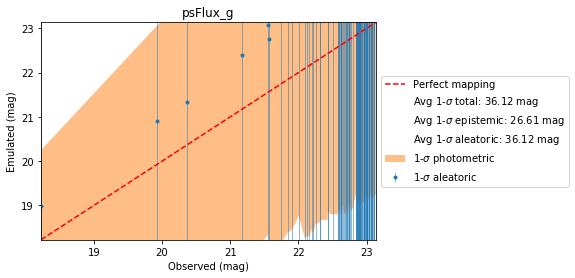

In [72]:
plot_flux_mapping(means_sampled, logvar_sampled, 'psFlux_g', band='g',
                  truth_flux_name='%s_flux', plot_offset=False)

### Plot pairwise marginal posterior

### Plot sampled posterior for a single object

### Marginal HPD intervals

In [182]:
Y_cols

['x',
 'y_obs',
 'ra_offset',
 'dec_offset',
 'Ixx',
 'Ixy',
 'Iyy',
 'IxxPSF',
 'IxyPSF',
 'IyyPSF',
 'cModelFlux_u',
 'cModelFlux_g',
 'cModelFlux_r',
 'cModelFlux_i',
 'cModelFlux_z',
 'cModelFlux_y',
 'psFlux_u',
 'psFlux_g',
 'psFlux_r',
 'psFlux_i',
 'psFlux_z',
 'psFlux_y',
 'u_base_CircularApertureFlux_70_0_instFlux',
 'g_base_CircularApertureFlux_70_0_instFlux',
 'r_base_CircularApertureFlux_70_0_instFlux',
 'i_base_CircularApertureFlux_70_0_instFlux',
 'z_base_CircularApertureFlux_70_0_instFlux',
 'y_base_CircularApertureFlux_70_0_instFlux',
 'u_ext_photometryKron_KronFlux_instFlux',
 'g_ext_photometryKron_KronFlux_instFlux',
 'r_ext_photometryKron_KronFlux_instFlux',
 'i_ext_photometryKron_KronFlux_instFlux',
 'z_ext_photometryKron_KronFlux_instFlux',
 'y_ext_photometryKron_KronFlux_instFlux']

/global/u1/j/jwp/fast-forward/units_utils.py:6: RuntimeWarning: invalid value encountered in log10
  return zeropoint_mag-2.5*np.log10(flux)


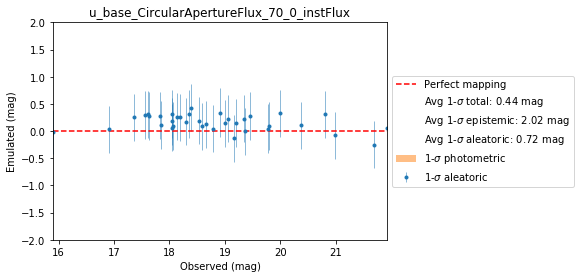

In [183]:
plot_flux_mapping(means_sampled, logvar_sampled, 'u_base_CircularApertureFlux_70_0_instFlux', 
                  truth_flux_name='%s_flux')

In [120]:
def plot_mapping(means, logvar, param, truth_flux_name='%s_flux'):
    epistemic_var_full = np.var(means, axis=0).mean(axis=0)
    aleatoric_var_full = np.mean(np.exp(logvar), axis=0)
    Y_coldict = dict(zip(Y_cols, range(Y_dim)))
    r_mag = units.flux_to_mag(X_val_sampled.loc[:, 'r_flux'].values, from_unit='nMgy')
    
    # Slice for this param
    param_ind = Y_coldict[param]
    mean_avg = np.mean(means, axis=0)[:, param_ind]
    epistemic_var = epistemic_var_full[param_ind]
    aleatoric_var = aleatoric_var_full[:, param_ind]
    total_var = aleatoric_var + epistemic_var
    display_var = aleatoric_var
    display_sig = display_var**0.5
    truth = Y_val_sampled.loc[:, param]
    # Plot pred in magnitudes
    mean_avg_mag = units.flux_to_mag(mean_avg, from_unit='nMgy')
    truth_mag = units.flux_to_mag(truth, from_unit='nMgy')
    plt.errorbar(truth_mag, mean_avg_mag, marker='.', linewidth=0, yerr=display_sig, elinewidth=0.5, label=r'1-$\sigma$ aleatoric')
    # Plot perfect mapping
    perfect = np.linspace(np.min(truth_mag), np.max(truth_mag))
    plt.plot(perfect, perfect, linestyle='--', color='r', label="Perfect mapping")
    # Plot obs error from known LSST systematics
    obs_err, sys_type = assign_obs_errors(param, Y_coldict, truth_flux_name, truth, r_mag)
    sorted_id = np.argsort(truth)
    sorted_truth = truth[sorted_id]
    plt.fill_between(sorted_truth, sorted_truth-obs_err[sorted_id], sorted_truth + obs_err[sorted_id], alpha=0.5, facecolor='tab:orange', label=r'1-$\sigma$ %s' %sys_type)

    # Subplot formatting
    plt.xlim([np.min(truth_mag), np.max(truth_mag)])
    plt.ylim([np.min(truth_mag), np.max(truth_mag)])
    plt.title(param)
    plt.ylabel("Emulated")
    plt.xlabel("Observed")
    plt.plot([], [], ' ', label=r"Avg 1-$\sigma$ total: %.2f" %np.mean((total_var)**0.5))
    plt.plot([], [], ' ', label=r"Avg 1-$\sigma$ epistemic: %.2f" %np.mean((epistemic_var)**0.5))
    plt.plot([], [], ' ', label=r"Avg 1-$\sigma$ aleatoric: %.2f" %np.mean((aleatoric_var)**0.5))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [83]:
def plot_marginal_mapping(means, logvar, truth_flux_name='flux_%s'):
    Y_dim = len(Y_cols)
    fig, axs = plt.subplots(Y_dim//2 + Y_dim%2, 2, figsize=(9*2, 6*(Y_dim//2)), 
                            facecolor='w', edgecolor='k')
    Y_coldict = dict(zip(Y_cols, np.arange(Y_dim)))
    r_mag = units.flux_to_mag(X_val_sampled.loc[:, 'r_flux'].values, from_unit='nMgy')
    axs = axs.ravel()
    
    # Preds
    epistemic_var_full = np.var(means, axis=0).mean(axis=0)
    aleatoric_var_full = np.mean(np.exp(logvar)*Y_mean.reshape([1, 1, Y_dim]), axis=0)
    for param in Y_cols:
        param_ind = Y_coldict[param]
        mean_avg = np.mean(means, axis=0)[:, param_ind]
        epistemic_var = epistemic_var_full[param_ind]
        aleatoric_var = aleatoric_var_full[:, param_ind]
        total_var = aleatoric_var + epistemic_var
        display_var = aleatoric_var
        display_sig = display_var**0.5
        truth = Y_val_sampled.loc[:, param]
        # Plot pred
        axs[param_ind].errorbar(truth, mean_avg, marker='.', linewidth=0, yerr=display_sig, elinewidth=0.5, label=r'1-$\sigma$ aleatoric')
        # Plot perfect mapping
        perfect = np.linspace(np.min(truth), np.max(truth))
        axs[param_ind].plot(perfect, perfect, linestyle='--', color='r', label="Perfect mapping")
        # Plot obs error from known LSST systematics
        obs_err, sys_type = assign_obs_errors(param, Y_coldict, truth_flux_name, truth, r_mag)
        sorted_id = np.argsort(truth)
        sorted_truth = truth[sorted_id]
        axs[param_ind].fill_between(sorted_truth, sorted_truth-obs_err[sorted_id], sorted_truth + obs_err[sorted_id], alpha=0.5, facecolor='tab:orange', label=r'1-$\sigma$ %s' %sys_type)
        
        # Subplot formatting
        axs[param_ind].set_title(param)
        axs[param_ind].set_ylabel("Emulated")
        axs[param_ind].set_xlabel("Observed")
        axs[param_ind].plot([], [], ' ', label=r"Avg 1-$\sigma$ total: %.2f" %np.mean((total_var)**0.5))
        axs[param_ind].plot([], [], ' ', label=r"Avg 1-$\sigma$ epistemic: %.2f" %np.mean((epistemic_var)**0.5))
        axs[param_ind].plot([], [], ' ', label=r"Avg 1-$\sigma$ aleatoric: %.2f" %np.mean((aleatoric_var)**0.5))
        axs[param_ind].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.subplots_adjust(wspace=1.0, hspace=0.5)
    #plt.tight_layout()

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in sqrt
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in sqrt
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in sqrt


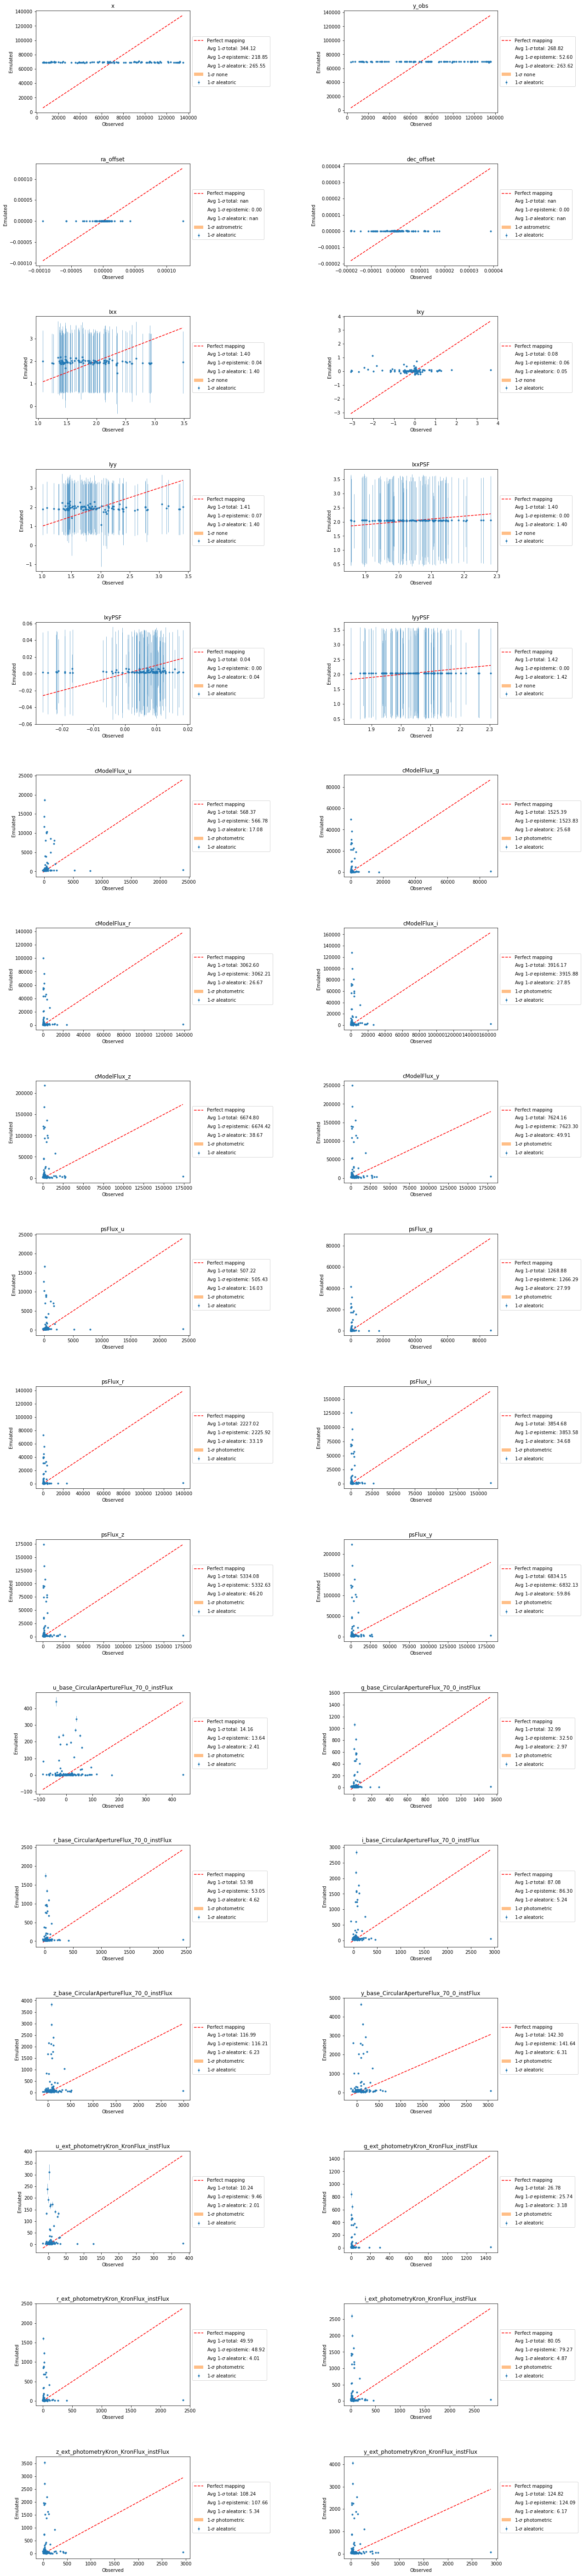

In [11]:
plot_marginal_mapping(means_sampled, logvar_sampled)

### Marginal offset evaluation

In [ ]:
def plot_marginal_offset(Y_val, means, logvar):
    n_params = Y_val.shape[1]
    fig, axs = plt.subplots(n_params//2, 2, figsize=(6*2, 4*(n_params//2)), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for param in range(n_params):
        mean_avg = np.mean(means, axis=0)[:, param]
        epistemic_var = np.var(means, axis=0).mean(axis=0)[param]
        aleatoric_var = np.mean(np.exp(logvar), axis=0)[:, param]
        total_var = aleatoric_var + epistemic_var
        display_var = 2.0*aleatoric_var # two sources of aleatoric uncertainty in the offset
        display_sig = 1000.0*display_var**0.5 # in milliunits
        truth = Y_val_sampled[:, param]
        offset = (mean_avg - truth)*1000.0 # mas or mmag
        if column_dict[param] in ['ra', 'dec']:
            r_mag = X_val_sampled.loc[:, 'r'].values
            obs_err = get_astrometric_err(r_mag)*np.sqrt(2)
            sys_type = 'astrometric'
        else: # magnitude columns
            band = column_dict[param].split('_')[1] # FIXME: hacky
            mag = X_val_sampled.loc[:, band].values
            obs_err = get_mag_err(mag, band)*1000.0*np.sqrt(2) # in mmag
            sys_type = 'photometric'
        sorted_id = np.argsort(truth)
        axs[param].fill_between(truth[sorted_id], -obs_err[sorted_id], obs_err[sorted_id], alpha=0.5, facecolor='tab:orange', label=r'1-$\sigma$ %s' %sys_type)
        axs[param].errorbar(truth, offset, marker='.', linewidth=0, yerr=display_sig, elinewidth=0.5, label=r'1-$\sigma$ aleatoric')
        perfect = np.linspace(np.min(truth), np.max(truth))
        axs[param].plot(perfect, np.zeros_like(perfect), linestyle='--', color='r', label="Perfect mapping")
        axs[param].set_title(column_dict[param])
        axs[param].set_ylabel("Emulated - Observed")
        axs[param].set_xlabel("Observed")
        axs[param].plot([], [], ' ', label=r"Avg 1-$\sigma$ total: %.2f" %np.mean((2.0*total_var)**0.5))
        axs[param].plot([], [], ' ', label=r"Avg 1-$\sigma$ epistemic: %.2f" %np.mean((2.0*epistemic_var)**0.5))
        axs[param].plot([], [], ' ', label=r"Avg 1-$\sigma$ aleatoric: %.2f" %np.mean((2.0*aleatoric_var)**0.5))
        axs[param].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.subplots_adjust(wspace=1.0, hspace=0.5)
    #plt.tight_layout()

In [ ]:
plot_marginal_offset(Y_val_sampled, means_sampled, logvar_sampled)

### Full posterior cornerplot

In [ ]:
def draw_cornerplot(pred, fig=None, color='black'):
    n_samples, n_data, n_params = means_sampled.shape
    plot = corner.corner(pred, 
                        color=color, 
                        smooth=1.0, 
                        labels=list(column_dict.values()),
                        #show_titles=True,
                        fill_contours=True,
                        bins=50,
                        fig=fig,
                        range=[0.999]*n_params,
                        hist_kwargs=dict(normed=True, ))
    return plot

In [ ]:
pred = np.mean(means, axis=0)
pairwise_post_pred = draw_cornerplot(pred, color='tab:blue')
pairwise_post_observed = draw_cornerplot(Y_val, fig=pairwise_post_pred, color='tab:orange')